# This script contains EEG-EMG preprocessing for isokinetic rectangle movements 
## Synchronization infomation is obtained with matlab scripts, event engineering is done via interaction with EEGLAB
## EEG/EMG denoising (4 srg)
- exclude bads from subsequent processing
- filtering: 1-45Hz for EEG, 10-200Hz for EMG
- srg epochs generation with PTP thresholding
- ICA fitting and exclusion
- visual inspection: noisy epochs removal
## EEG/EMG denoising (4 motor trials)
## motor epochs identification
We should identify epochs of diff sorts before calculating the muscle synergy
## data description:
- four motor patterns: up, right, down, left for right hands (i.e. clockwise); up, left, down, right for left hands (anticlockwise). We define them as **push**, horizontal abduction (**habd**), **pull**, and horizontal adduction (**hadd**)
- four CMN assessments with a week interval in between
- four groups: conventional therapy (subj51, 52), longterm 1Hz rTMS (subj43, 46, 47, 54, 55), longterm 10Hz rTMS (subj56, 57), longterm sham rTMS (subj42)
- two sorts of CMN: resting state FBC and task-related CMN
## 2 explore
- motor synergy (factorization thing)， CMC between EEG and the weight of each synergy
- from EMG to muscle activation (for example, bandpass 20-400 - sfreq = 1000, full-wave rectification) 
- the effect of SPMI parameters
- iMC vs iVC, we see discontinuous EMG during iVC, so EMG envelop might be a compromised method. iMC paradigm is suitable for diagnosis. This concern can be addressed with muscle activation (smoother)
- NMF, V=WH where w is known. Not really exist, but it is essentially a optimisation problem
## Notes
- Channel 0-7 are valided EMG chs for most of the subjects. In some case, the recorded channels were not 0-7 because of technical hitches during the exp (subj56,57).
- markers sometime were mistaken during the experiment, plz be careful and patient when adjusting markers. A good practice is to look at the onset of the first pull where EMG data normally show a ramp. Besides, the interval of each action (e.g. push, habd) should be roughly equal. Spotting the periodity help to eliminate the mistakes, for example, module 0 (TBL+LD) has great activation during push. To interact with EEGLAB, open the dataset, modify the event by '''EEG.event(43).latency = 98100,''', then click edit-dataset info-ok, and save the current dataset
- Convention in this script: data means the numpy array type, raw/Epochs are of mne type

# Global definition & util fcs

In [44]:
import mne
import pandas as pd
import os
import numpy as np
from mne.preprocessing import ICA
from mne.preprocessing import read_ica
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib qt

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def s_entropy_withP(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    n_zeros = np.count_nonzero(freq_list==0)
    sh_entropy = n_zeros/len(freq_list)
    freq_list = [element for element in freq_list if element != 0]
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def p_entropy_withP(op):
    ''' Different from P_entropy: the max_entropy is calculated using the len(non_zero(op))
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    # op: ordinal pattern
#     ordinal_pat_nonzero = [element for element in op if element != 0]
#     max_entropy = np.log(len(ordinal_pat_nonzero))
#     p = np.divide(np.array(ordinal_pat_nonzero), float(sum(ordinal_pat_nonzero)))
#     return(s_entropy(p)/max_entropy)
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy_withP(p)/max_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    lst = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_permutations):
        for i in range(len(possible_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)

def p_entropy(op):
    # op: ordinal pattern
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    # take care of the variance within a observed pattern
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    temp_list = list()
    wop = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        Xi = time_series[i:(embdim+i)]
        Xn = time_series[(i+embdim-1): (i+embdim+embdim-1)]
        Xi_mean = np.mean(Xi)
        Xi_var = (Xi-Xi_mean)**2
        weight = np.mean(Xi_var)
        sorted_index_array = list(np.argsort(Xi))
        temp_list.append([''.join(map(str, sorted_index_array)), weight])
    result = pd.DataFrame(temp_list,columns=['pattern','weights'])
    freqlst = dict(result['pattern'].value_counts())
    for pat in (result['pattern'].unique()):
        wop.append(np.sum(result.loc[result['pattern']==pat,'weights'].values))
    return(wop)

def joint_ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of two time series for a given embedding dimension and embedding delay.
    USAGE: joint_ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing two time series ,shape =(2,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series_x = ts[0]
    time_series_y = ts[1]
    possible_permutations = list(itertools.permutations(range(embdim)))
    possible_permutations_repeat = np.repeat(np.array(list(itertools.permutations(range(embdim)))),6,axis=0)
    possible_permutations_interlace = np.array(list(itertools.permutations(range(embdim)))*6)
    possible_joint_permutations = np.concatenate((possible_permutations_repeat,possible_permutations_interlace),axis=1)
    lst_x = list()
    lst_y = list()
    lst = list()
    for i in range(len(time_series_x) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series_x[i:(embdim+i)]))
        lst_x.append(sorted_index_array)
        sorted_index_array = list(np.argsort(time_series_y[i:(embdim+i)]))
        lst_y.append(sorted_index_array)
    lst_x = np.array(lst_x)
    lst_y = np.array(lst_y)
    lst = np.concatenate ((lst_x,lst_y),axis=1)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_joint_permutations):
        for i in range(len(possible_joint_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)
    
def PMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)

def PMI_2chs_withP(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy_withP(op_x)
    p_y = p_entropy_withP(op_y)
    p_xy = p_entropy_withP(op_xy)
    return (p_x+p_y-p_xy)

def PMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            PMI[i,j] = (p_x+p_y-p_xy)
    return PMI

def PMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                PMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)
    return PMI

def SPMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)/p_xy

def SPMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the SPMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    SPMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            SPMI[i,j] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def SPMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the SPMI for epochs.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: assymmetric SPMI matrix
    '''
    SPMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                SPMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def get_ch_name(epochs,ch_idx,emg_map=None):
    '''
    This function works when the number of EEG electrode is 32.
    if the emg mapping was given, the function return the muscle related to the emg electrod. 
    '''
    if ch_idx<32:
        return (epochs.info['ch_names'][ch_idx])
    elif ch_idx<40:
        if emg_map == None:
            return ('emg'+str(ch_idx-31))
        else:
            return emg_map['emg'+str(ch_idx-31)]
    else:
        return 0

def is_symmetric(a,tol = 1e-3):
    return (np.abs(a - a.T) <= tol).all()    
    
def chs_remap(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == False:
        cons =  cons + cons.T - np.diag(np.diag(cons))
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T7c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped

def chs_remap4directionalCons(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == True:
        print("please make sure that the connectivity measure is directional")
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T7c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped

def emg2synergy(emg_data, emg_ch_names, show=True, n_components= 3):
    '''
    parameters
    ----------
    emg_data: 2D numpy array (chs, time)
    emg_ch_names: list of str
    show: whether to visualize muscle synergy
    n_components: None or int. It should be greater than 2. Default 3. If specified, NMF will yield 3 muscle synergies. If None, n_components = number of chs - 2 
    
    Notes
    -----
    We do not specify VAF_threhold and VAF_diff_threshold
    '''
    # build aligned_synergy_raw with muscle activation and synergic module factorization
    emg_data4muscleActivation = emg_data.copy()
    emg_data4muscleActivation = mne.filter.filter_data(emg_data4muscleActivation,sfreq=1000, l_freq=20, h_freq=400, method = 'iir') #  bandpass to correct artifacts
    emg_data4muscleActivation -= emg_data4muscleActivation.mean(axis = 1)[:, None] #  demean
    emg_data4muscleActivation = np.abs(emg_data4muscleActivation) #  rectification
    emg_data4muscleActivation = emg_data4muscleActivation / np.max(emg_data4muscleActivation) #  normalization
    # emg_data2test /= emg_data2test.max(axis=1)[:, None] #  find max for each ch

    emg_data4muscleActivation = mne.filter.filter_data(emg_data4muscleActivation,
                                                       sfreq=1000, l_freq=None, h_freq=45, method = 'iir') #  low-pass smoothing, 
                                                                                                          #  please note that negative values appear in this step
    # muscle excitation (recursive filter)
    d = 10 # 10ms
    c1 = 0.5
    c2 = 0.5
    beta1 = c1+c2
    beta2 = c1*c2
    alpha = 1+beta1+beta2
    muscle_excitation = np.zeros(emg_data4muscleActivation.shape)
    for i in range(emg_data4muscleActivation.shape[1]-d):
        muscle_excitation[:,i+d] = alpha*emg_data4muscleActivation[:,i] - beta1*muscle_excitation[:,i+d-1] - beta2*muscle_excitation[:,i+d-2]
    # muscle activation
    A = -1.5
    muscle_activation = (np.exp(A*muscle_excitation) - 1) / (np.exp(A) -1)
    if np.min(muscle_activation) < 0: #  handle negative values
        muscle_activation -= np.min(muscle_activation) 

    # non-negative matrix factorization iterate from 2 
    # stopping condition: as the n_components increase, the reconstruction error (Frobenius norm of the matrix difference) does not reduce significantly
    # In practice, the n_compoents stop increasing when VAF(n + 1) - VAF(n) < 0.05 or VAF(n) > 0.85
    VAF_diff = 1
    VAF_n = 0
    assert len(emg_ch_names) > 2, "must have more than 2 emg chs"
    if n_components == None:
        n_components = len(emg_ch_names) - 2
    n_components_init = 2
    VAF = []
    VAF_diff = []
    n_componentsInLoop = n_components_init
    while (n_componentsInLoop < (len(emg_ch_names) - 1)): 
        model_n = NMF(n_components=n_componentsInLoop, init='random', random_state=0, max_iter=10000) #  max iteration is set to 10000
        model_n.fit_transform(muscle_activation)
        if n_componentsInLoop == n_components:
            muscle_synergy = model_n.fit_transform(muscle_activation)
            synergy_factor = model_n.components_  #  the activation time course
        VAF_n = 1 - model_n.reconstruction_err_ / np.linalg.norm(muscle_activation) #  frobenius norm
        model_nPlus1 = NMF(n_components=n_componentsInLoop+1, init='random', random_state=0, max_iter=10000)
        model_nPlus1.fit_transform(muscle_activation)
        VAF_nPlus1 = 1 - model_nPlus1.reconstruction_err_ / np.linalg.norm(muscle_activation)
        VAF_diff_n = np.abs(VAF_n - VAF_nPlus1)
        VAF.append(VAF_n)
        VAF_diff.append(VAF_diff_n)
        n_componentsInLoop +=1
    df_muscle_synergy = pd.DataFrame(muscle_synergy.T, columns = emg_ch_names)
    if show == True:
        fig, axes = plt.subplots((n_components-1) // 4 + 1, 4, figsize=(24,18)) #  four cols
        if n_components > 4:
            for num_synergy in range(n_components):
                sns.barplot(ax=axes[num_synergy // 4, num_synergy % 4],x=df_muscle_synergy.columns, y=df_muscle_synergy.iloc[num_synergy].values,
                            color=sns.color_palette(n_colors=synergy_factor.shape[0])[num_synergy],
                            label = 'synergy_' + str(num_synergy))
                axes[num_synergy // 4, num_synergy % 4].set_title('synergic module' + str(num_synergy))
        else:
            for num_synergy in range(df_muscle_synergy.shape[0]):
                sns.barplot(ax=axes[num_synergy % 4],x=df_muscle_synergy.columns, y=df_muscle_synergy.iloc[num_synergy].values,
                            color=sns.color_palette(n_colors=synergy_factor.shape[0])[num_synergy],
                            label = 'synergy_' + str(num_synergy))
                axes[num_synergy % 4].set_title('synergic module' + str(num_synergy))
        plt.show()
    return muscle_synergy, synergy_factor, VAF, VAF_diff       

data_dir = 'E:/masterSJTU/MultiEEGEMG_stroke'
sfreq_emg = 1000
sfreq_eeg = 500

bad_eeg_chs = {'51':
               {'rest': {'01': [], '02': [], '03': [], '04': []},
                'iVC': {'s01': ['T8'], 's02': ['T8'], 's03': ['O1', 'T8'], 's04': ['P8'], 's05': [], 's06': ['P4'],
                        's07': [], 's08': ['FC1'], 's09': ['O1', 'FC1'], 's10': ['PO4'], 's11': ['PO4'], 's12': ['PO4']}},
               '59':
               {'rest': {'01': [], '02': [], '03': [], '04': []},
                'iVC': {'s01': [], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                        's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []}},
               '61':
               {'rest': {'01': [], '02': [], '03': [], '04': []},
                'iVC': {'s01': ['P8'], 's02': ['P8'], 's03': [], 's04': [], 's05': [], 's06': [],
                        's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []}},
              }

ICs2remove = {'51': {'rest': {'01': [], '02': [], '03': [], '04': []},
                     'srg': {'s01': [0, 1, 3, 8], 's02': [0, 1, 5, 13], 's03': [1, 2, 3], 's04': [0,2], 's05': [0, 1], 's06': [0, 1],
                             's07': [0, 9],       's08': [0, 1, 6], 's09': [0, 2, 8, 13], 's10': [0, 1, 2, 4], 's11': [0, 1, 11, 16], 's12': [0, 2]},
                     
                     'push': {'s01': [0, 2],    's02': [15], 's03': [1, 12], 's04': [0, 2, 3, 5, 6], 's05': [1, 2, 5], 's06': [0, 3],
                              's07': [1, 2, 5], 's08': [1, 2, 6], 's09': [1, 2, 14], 's10': [1, 6], 's11': [0, 1, 4, 5, 6], 's12': [8]},
                     
                     'habd': {'s01': [0, 2, 3, 6], 's02': [14], 's03': [3], 's04': [0, 2, 3], 's05': [0, 2, 3, 4], 's06': [2, 5, 6],
                              's07': [1, 4, 5],    's08': [1, 2, 6, 8], 's09': [2], 's10': [0], 's11': [1, 3], 's12': [7]},
                     
                     'pull': {'s01': [3, 5],    's02': [3], 's03': [], 's04': [3, 5], 's05': [0, 2, 3, 4, 5], 's06': [1],
                              's07': [0, 1, 8], 's08': [2, 4, 10], 's09': [2, 6], 's10': [1, 2, 13], 's11': [1, 7], 's12': [4]},
                     
                     'hadd': {'s01': [0, 4, 6],    's02': [], 's03': [14], 's04': [0, 2, 3, 4], 's05': [1], 's06': [1, 2, 3],
                              's07': [0, 1, 3, 4], 's08': [2, 5, 12], 's09': [3, 7], 's10': [0], 's11': [0, 1], 's12': [3]}
                     },
              '61': {'rest': {'01': [], '02': [], '03': [], '04': []},
                     'srg': {'s01': [0, 1, 3, 8], 's02': [0, 1, 5, 13], 's03': [], 's04': [], 's05': [], 's06': [],
                             's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'push': {'s01': [0, 2], 's02': [15], 's03': [], 's04': [], 's05': [], 's06': [],
                              's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'habd': {'s01': [0, 2, 3, 6], 's02': [14], 's03': [], 's04': [], 's05': [], 's06': [],
                              's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'pull': {'s01': [3, 5], 's02': [3], 's03': [], 's04': [], 's05': [], 's06': [],
                              's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'hadd': {'s01': [0, 4, 6], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                              's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []}
                     },
             }

epochs_rejected ={'51': {'rest': {'01': [], '02': [], '03': [], '04': []},
                         'srg': {'s01': [], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                             's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                         'push': {'s01': [], 's02': [7, 8], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                         'habd': {'s01': [], 's02': [8, 9, 10], 's03': [0, 6], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': [6, 7]},
                         'pull': {'s01': [10], 's02': [7, 8, 9, 10], 's03': [5], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [0], 's12': []},
                         'hadd': {'s01': [10], 's02': [7, 8], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [10], 's09': [], 's10': [], 's11': [], 's12': [2]}
                         },
                 }

Channels marked as bad: ['T8']
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none


# Prerequisite
## synchronized EEG-EMG visulization 
This script provides info to correct mistakenly marked events via EEGLAB and help spot bad channels. Outputs are raw_eeg, raw_emg, and raw_hybrid which have the same length 
## Output: band-passed aligned data *raw_aligned*
The 45Hz LP smoothing is chosen as to make the frequency bin of majoarity of EEG/EMG is the same before SPMI calculation. \
If the last epoch (marked by the marker) is unable to last 3s, we delete this event in EEGLAB \
Dont panic when assertion presents, it serve as a warning \
**rerun this cell after updating the bad chs**

In [46]:
# definition #
subj_idx = '51'      # editable variables
session_idx = 's01' # editable variables
%matplotlib qt
reject_criteria = dict(eeg=6e-4, emg=2e-2)       # 600 μV for EEG, 20mV for EMG, do not exclude epochs containing ocular artifact
flat_criteria = dict(eeg=1e-6, emg=1e-6)
sfreq_emg = 1000
sfreq_eeg = 500
data_dir = 'E:/masterSJTU/MultiEEGEMG_stroke'
dir_list = ['epochs', 'ica', 'raw', 'synergy']
for dirName in dir_list:
    exec(dirName + '_dir=os.path.join(data_dir,"subj' + subj_idx + '","' + dirName + '")')
    exec('if not os.path.exists(' + dirName+ '_dir): os.makedirs(' + dirName + '_dir)')
      
# exec fc to create fNames (including band-passed and preped, aka, after ICA) 4 diff types of epochs e.g. push_epochs_fName    
epochs_types = ['srg', 'push', 'habd', 'pull', 'hadd']
isSynergy = ['', '_synergy']
for epochs_type in epochs_types:
    exec('df_' + epochs_type + '_muscle_synergy_fName = os.path.join("' + synergy_dir + '","subj' + subj_idx + '_iVC_' + session_idx+ \
        '_'+ epochs_type + '_muscle_synergy.csv")')
    exec('df_' + epochs_type + '_VAF_fName = os.path.join("' + synergy_dir + '","subj' + subj_idx + '_iVC_' + session_idx+ \
        '_'+ epochs_type + '_VAF.csv")')
    for emg_type in isSynergy:
        exec(epochs_type + emg_type + "_epochs_fName = os.path.join('" + epochs_dir + "', 'subj" + \
             subj_idx + "_iVC_" + session_idx + "_" + epochs_type + emg_type + "_epo.fif')")
        exec(epochs_type + emg_type + "_epochs_prepped_fName = os.path.join('" + epochs_dir + "', 'subj" \
             + subj_idx + "_iVC_" + session_idx + "_" + epochs_type + emg_type + "_prepped_epo.fif')")
        exec(epochs_type + emg_type + "_ica_fName = os.path.join('" + ica_dir + "', 'subj" + subj_idx + \
             "_iVC_" + session_idx + "_" + epochs_type + emg_type + "_ica.fif')")

aligned_raw_fName = os.path.join(raw_dir,'subj' + subj_idx + '_iVC_' + session_idx + '_aligned_raw.fif')
aligned_synergy_raw_fName = os.path.join(raw_dir,'subj' + subj_idx + '_iVC_' + session_idx + '_aligned_synergy_raw.fif')
emg_fName = os.path.join(data_dir, 'subj'+subj_idx, 'EMG', 'subj'+subj_idx+'_iVC_'+session_idx+'.txt')
eeg_fName = os.path.join(data_dir, 'subj'+subj_idx, 'EEG', 'subj'+subj_idx+'_iVC_'+session_idx+'.set')
alignmentInfo_fName = os.path.join(data_dir, 'subj'+subj_idx, 'subj'+subj_idx+'_alignmentInfo.txt')
alignmentInfo = pd.read_csv(alignmentInfo_fName, skiprows=0, sep=',', engine='python')

# read and cut EEG #
eeg_raw = mne.io.read_raw_eeglab(eeg_fName, preload=True)
if subj_idx not in bad_eeg_chs.keys():
    print('please update the bad chs list and add '+subj_idx+'in it')
eeg_raw.info['bads'] = bad_eeg_chs[subj_idx]['iVC'][session_idx]
eeg_raw.set_montage('standard_1020')
eeg_raw.crop(tmin=alignmentInfo.loc[(alignmentInfo['sessionIdx'] == session_idx) &
                                    (alignmentInfo['contraction_type'] == 'iVC'),
                                    'EEG'].values[0] / eeg_raw.info['sfreq'])
eeg_raw.filter(l_freq=1, h_freq=45)

# read and cut EMG #
ch_types = ['emg'] * 8  # ther are actually EMG redefined as 'ECG' to trick mne
emg_ch_names = ['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD']
info = mne.create_info(ch_names=emg_ch_names, sfreq=sfreq_emg, ch_types=ch_types)
emg_data = pd.read_csv(emg_fName, header=None, skiprows=3,
                       sep=' ', usecols=np.arange(0, 8), skipfooter=0, engine='python')
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) &
                                          (alignmentInfo['contraction_type'] == 'iVC'),
                                          'EMG'].values[0]:, :].values
emg_data=emg_data.T / 1e6  # uV to V

emg_raw = mne.io.RawArray(emg_data, info)
emg_raw.filter(l_freq=10, h_freq=250, picks='all')
emg_raw.resample(sfreq=sfreq_eeg)

# data alighment #
t_end = min(len(eeg_raw), len(emg_raw)) / sfreq_eeg - 1/sfreq_eeg  # find the shortest length of EEG and EMG
emg_raw.crop(tmax=t_end)
eeg_raw.crop(tmax=t_end)
emg_raw.info['highpass'] =  eeg_raw.info['highpass']  # In reality, EEGs are bandpassed from 1-45Hz, EMGs are bandpassed from 10-200Hz
emg_raw.info['lowpass'] = eeg_raw.info['lowpass']
eeg2merge_raw = eeg_raw.copy()
aligned_raw = eeg2merge_raw.add_channels([emg_raw])

aligned_raw.plot(scalings=dict(eeg=1e-4, emg=1e-3), duration=20, n_channels=10, title='aligned_raw')
aligned_raw.save(fname=aligned_raw_fName, overwrite=True)

# check arithmetic sequence of events #
events,events_id = mne.events_from_annotations(aligned_raw)
type_events = events[:, 2]
assert np.all(type_events[4:] == type_events[:-len(type_events) % len(events_id)-4]), 'missing marker detection'

Channels marked as bad: ['T8']
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj51\EEG\subj51_iVC_s01.fdt
Reading 0 ... 109999  =      0.000 ...   219.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 sec)

Creating RawArray with float64 data, n_channels=8, n_times=209999
    Range : 0 ... 209998 =      0.000 ...   209.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Set

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


Closing E:\masterSJTU\MultiEEGEMG_stroke\subj51\raw\subj51_iVC_s01_aligned_raw.fif
[done]
Used Annotations descriptions: ['1', '2', '3', '4']


# preprocessing 
## Step 1: Surrogate Epochs generation (with EMG), synergy calculation (with sfreq_emg = 1000) and ICA fitting
Note that flat line and burst rejection apply during srg epochs generation
### df_muscle synergy
| 8chsProportion | n_synergy | n_epochs |
| --- | --- | --- |
| \[1,0.5,0.7,...\] | 0 | 0 |
| \[1,0.5,0.7,...\] | 1 | 0 |
| \[1,0.5,0.7,...\] | 2 | 0 |
| \[1,0.5,0.7,...\] | 0 | 2 |
### df_VAF
| VAF_nIs2 | VAF_nIs3 | ... | VAF_diff_nIs2 | VAF_diff_nIs3 | ... | n_epochs |
| -------- | -------- | --- | ------------- | ------------- | --- | -------- |
| 0.92 | 0.93 | ... | 0.02 | 0.03 | ... | 0 |
| 0.92 | 0.93 | ... | 0.02 | 0.03 | ... | 1 |

In [47]:
'''
The length of baseline segment is 18s, we generate 30 3s epochs with a step of 0.5s
'''
srg_tmin = 0.0
srg_tmax = 18.001
length_epochs = 3
n_srg_epochs = 30
sliding_step = 0.5

# create epochs_srg #
srg_raw = aligned_raw.copy().crop(tmin=srg_tmin, tmax=srg_tmax)
srg_onsets = np.arange(0, n_srg_epochs*sliding_step, sliding_step)
durations = [0.] * len(srg_onsets)
descriptions = ['srgOnset'] * len(srg_onsets)
annot_srg = mne.Annotations(onset=srg_onsets, duration=durations,
                            description=descriptions,
                            orig_time=aligned_raw.info['meas_date'])
srg_raw.set_annotations(annot_srg)

events, events_id = mne.events_from_annotations(srg_raw)
srg_epochs = mne.Epochs(srg_raw, events, tmin=0.0, tmax=length_epochs, reject=reject_criteria,
                        flat=flat_criteria, baseline=None, preload=True)
srg_epochs.save(srg_epochs_fName, overwrite=True)

# calculate muscle synergy epochs
srg_onsets_samplePoints = sfreq_emg * srg_onsets
synergy_factor_epochs_data = []
n_components = 4
muscle_synergy_data = []
VAF2df = []
VAF_diff2df = []
for onset in srg_onsets_samplePoints:
    muscle_synergy, synergy_factor, VAF, VAF_diff = emg2synergy(emg_data[:,int(onset):int(onset+length_epochs*sfreq_emg+2)],  #  3002 -> 1501 for 3s
                                                                emg_ch_names = emg_ch_names, show=False, n_components=n_components) #  2get the same length
    synergy_factor_epochs_data.append(synergy_factor)
    muscle_synergy_data.append(muscle_synergy)
    VAF2df.append(VAF)
    VAF_diff2df.append(VAF_diff)
    
muscle_synergy_data2df = np.zeros((len(srg_onsets_samplePoints)*n_components, len(emg_ch_names)+2))
for n_synergy in range(n_components):
    for n_epoch in range(len(srg_onsets_samplePoints)):
        muscle_synergy_data2df[(n_epoch)*n_components+n_synergy,:] = np.hstack([muscle_synergy_data[n_epoch].T[n_synergy], [n_synergy, n_epoch]])
df_muscle_synergy = pd.DataFrame(data=muscle_synergy_data2df, columns=emg_ch_names+['n_synergy','n_epoch'])
df_muscle_synergy.to_csv(df_srg_muscle_synergy_fName)

VAF_data2df = np.zeros((len(VAF2df), 2 * np.shape(VAF2df)[1] + 1))
for n_compoent in range(np.shape(VAF2df)[1]): #  range of n_components based on which NMF was fitted
    for n_epoch in range(np.shape(VAF2df)[0]): #  number of epochs
        VAF_data2df[n_epoch,:] = np.hstack([VAF2df[n_epoch],VAF_diff2df[n_epoch],[n_epoch]])
df_VAF = pd.DataFrame(data=VAF_data2df, columns=['VAF_'+str(i+2) for i in range(np.shape(VAF2df)[1])] +\
                      ['VAF_diff_'+str(i+2) for i in range(np.shape(VAF2df)[1])] + ['n_epoch']) #  n starts from 2
df_VAF.to_csv(df_srg_VAF_fName)

# ICA fitting #
ica = ICA(n_components=0.99, random_state=97)
ica.fit(srg_epochs)
ica.plot_sources(srg_epochs, stop=3, title='srg_icaSource')
ica.plot_components(inst=srg_epochs, title='srg_icaTopo')
ica.save(srg_ica_fName)


Used Annotations descriptions: ['srgOnset']
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effe

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_srg_ica.fif...


<ICA | epochs decomposition, fit (fastica): 45030 samples, 13 components, channels used: "eeg">

## Step 2: ICA removal for srg epochs
This cell should be run directly after step 1, ica should not be modified after running step 1 <br>
**update ICA2remove list before running this cell** 


Applying ICA to Epochs instance
    Transforming to ICA space (13 components)
    Zeroing out 4 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dropped 0 epochs: 


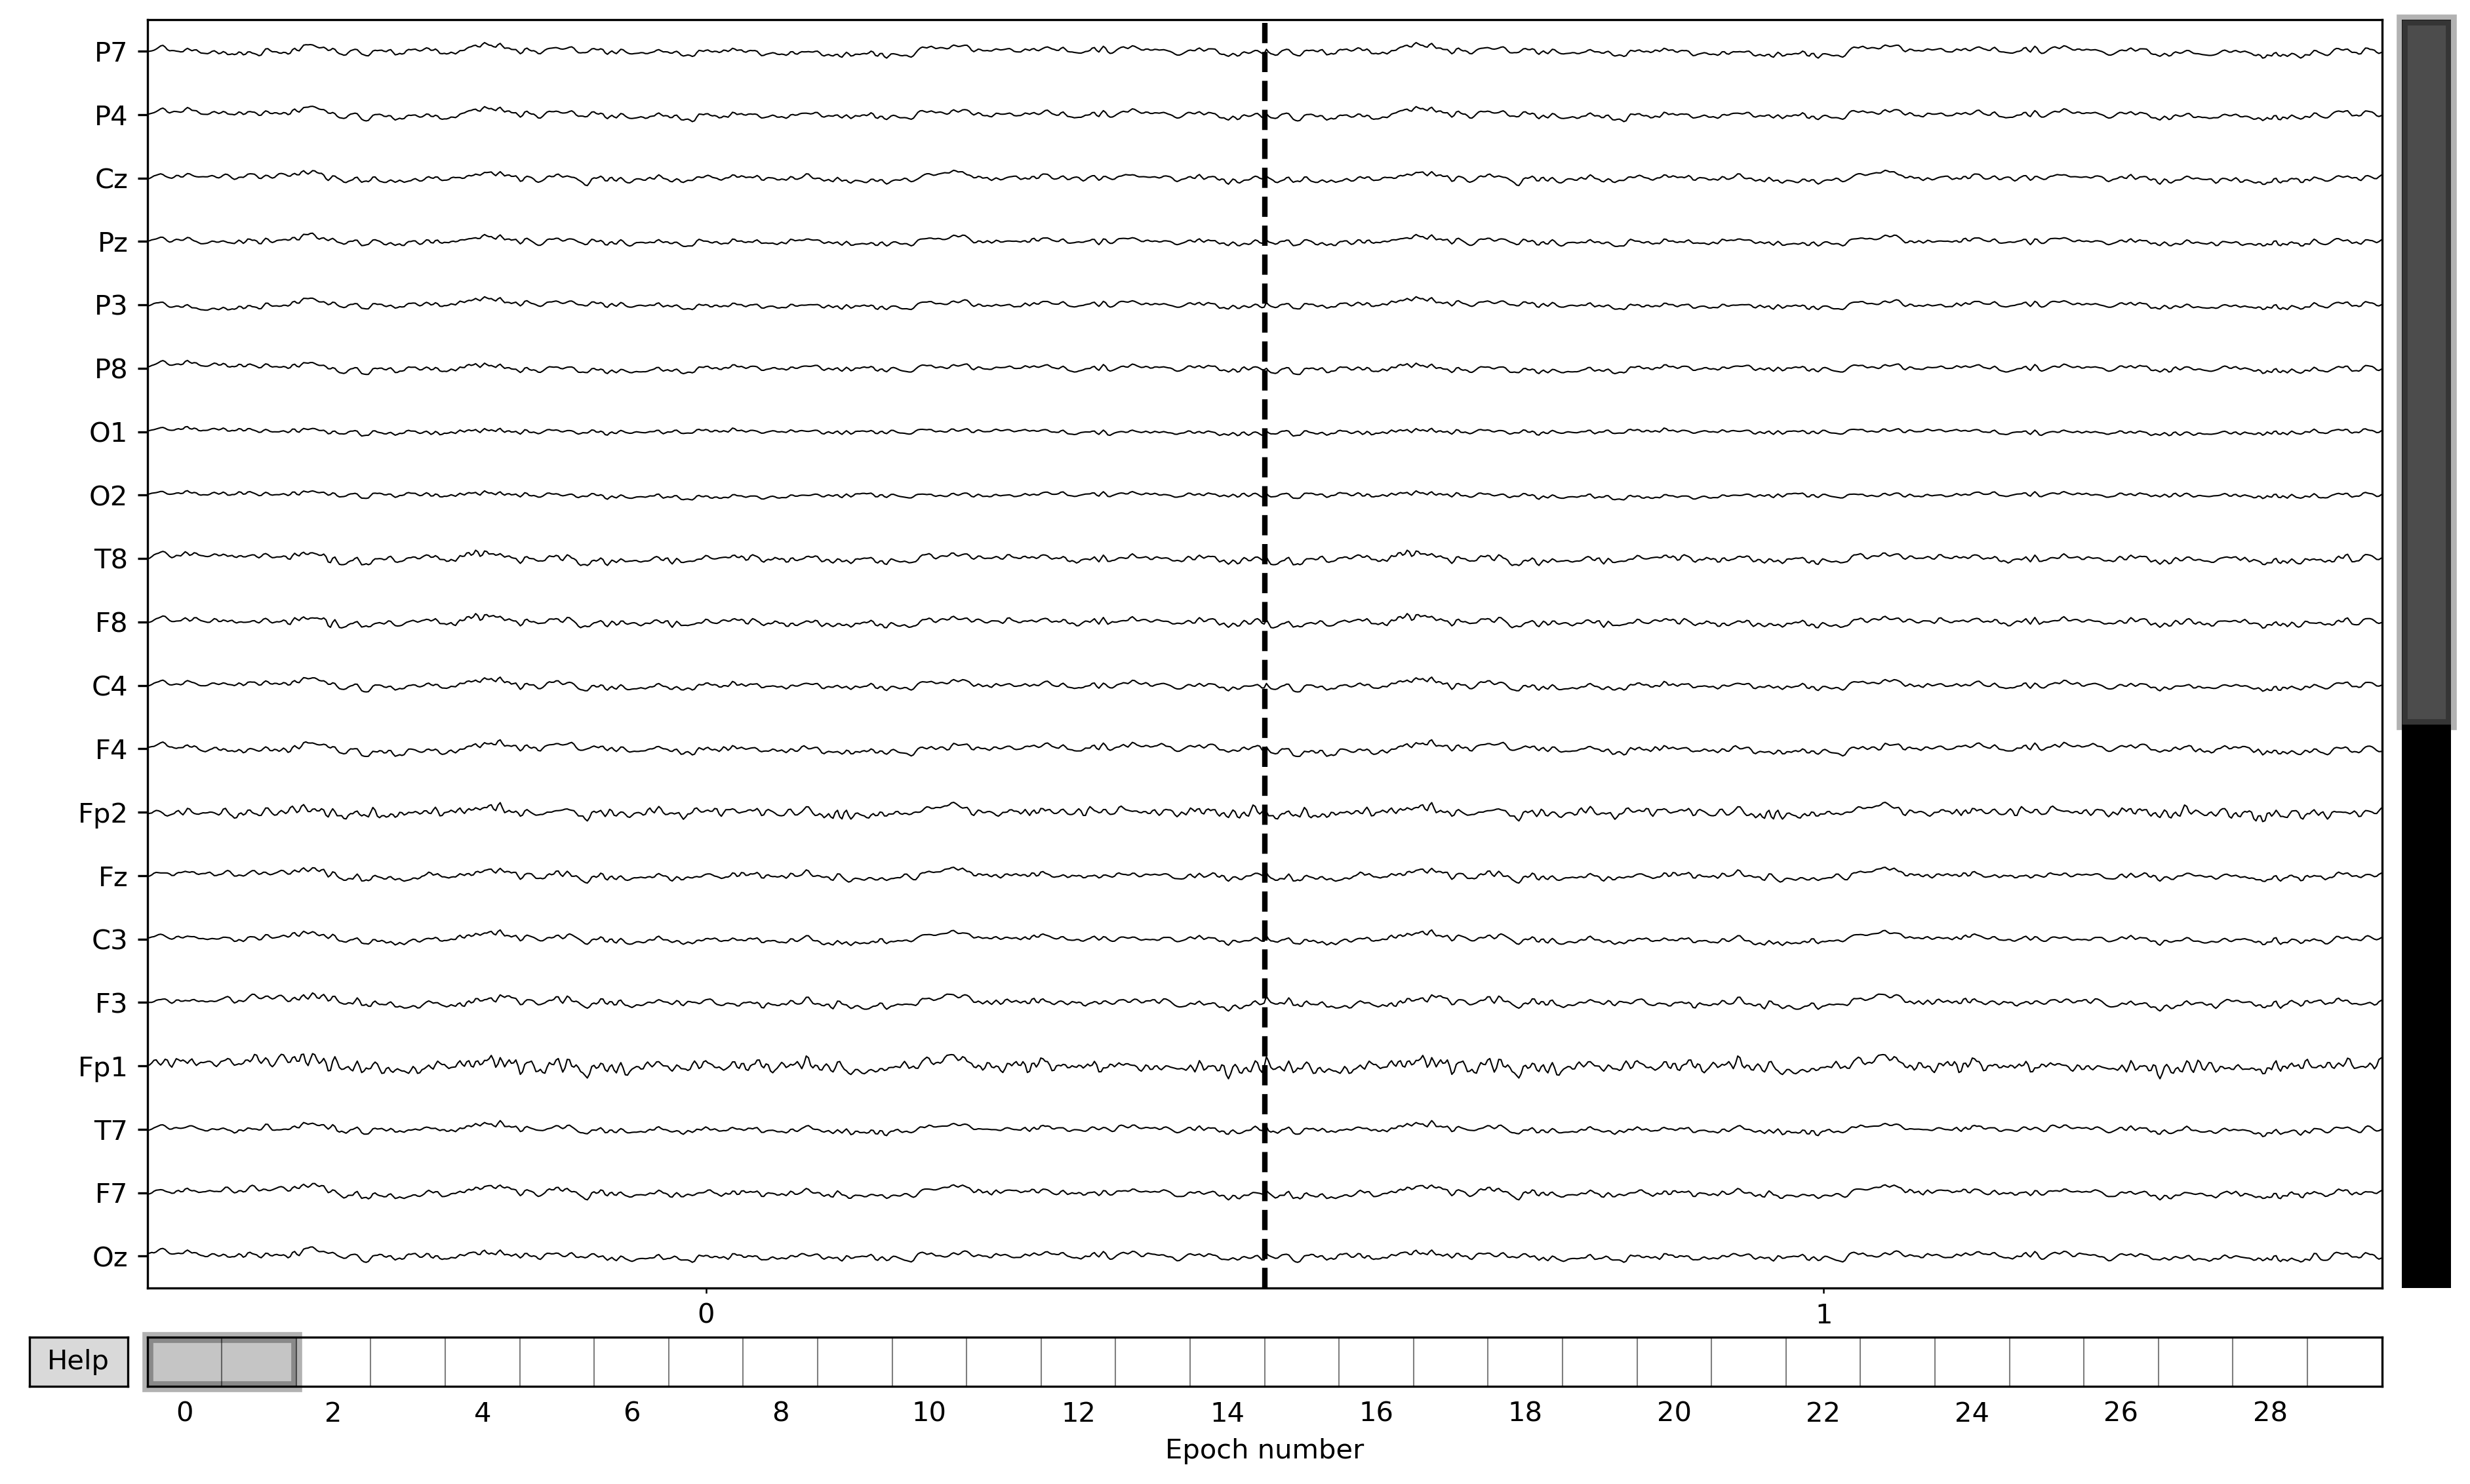

In [48]:
# update ICA 
ica.exclude = ICs2remove[subj_idx]['srg'][session_idx]
srg_epochs_prepped = srg_epochs.copy()
ica.apply(srg_epochs_prepped)
srg_epochs_prepped.interpolate_bads()
srg_epochs_prepped.save(srg_epochs_prepped_fName, overwrite=True)
srg_epochs_prepped.plot(scalings=dict(eeg=1e-4, emg=srg_epochs_prepped.get_data().max()/2), n_epochs=3, picks="all", title="srg_epochs_prepped")

ch_types = ['emg'] * np.shape(synergy_factor_epochs_data)[1]  # number of synergies
synergy_ch_names = ['synergy_' + str(i+1) for i in range(np.shape(synergy_factor_epochs_data)[1])]
info = mne.create_info(ch_names=synergy_ch_names, sfreq=sfreq_emg, ch_types=ch_types)
srg_synergy_epochs = srg_epochs_prepped.copy()
srg_synergy_epochs.drop_channels(emg_ch_names)
synergy_epochs = mne.EpochsArray(synergy_factor_epochs_data,info=info).resample(sfreq=sfreq_eeg)
synergy_epochs.info['highpass'] = srg_synergy_epochs.info['highpass']
synergy_epochs.info['lowpass'] = srg_synergy_epochs.info['lowpass']

### We are here handling drop epochs
epoch_idx = 0
bad_epochs_idx=[]
for i in srg_epochs_prepped.drop_log:
    if i==():
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
synergy_epochs.drop(bad_epochs_idx)
###############################

srg_synergy_epochs.add_channels([synergy_epochs])
srg_synergy_epochs.save(srg_synergy_epochs_prepped_fName, overwrite=True)
srg_synergy_epochs.plot(n_epochs=2, scalings=dict(eeg=1e-4, emg=srg_synergy_epochs.get_data().max()/2), picks='all', title="srg_synergy_epochs_prepped")

## Step 3: generate motor epochs of 4 sorts, calculate synergies 4 diff types of motor pattern, and ICA fitting
We do not apply epoch rejection during epochs generation (remove reject=reject_criteria,flat=flat_criteria). We keep the option at the visual inspection step \
**Note**: events from annotation would not change after cropping, only raw.first_samp changes. So we should add the first_samp when finding timestamps for emg

In [55]:
# Generate emg/synergy hybrid epochs based on events
events, events_id = mne.events_from_annotations(aligned_raw)
type_event_dict = {'push': 1, 'habd': 2, 'pull': 3, 'hadd': 4}
for epochs_type in type_event_dict.keys():
    exec('events_' + epochs_type + '= events[events[:,2]==type_event_dict[epochs_type]]')
    exec('onsets_samplePoints = ((events_' + epochs_type + '[:,0] - aligned_raw.first_samp) * sfreq_emg / sfreq_eeg - \
    alignmentInfo.loc[(alignmentInfo["sessionIdx"]==session_idx) & (alignmentInfo["contraction_type"] == "iVC"), \
                                          "EMG"].values[0]).astype(int)')
    exec(epochs_type + '_epochs = mne.Epochs(aligned' + '_raw, events_' + epochs_type + \
         ', tmin=0.0, tmax=length_epochs, baseline=None, preload=True)')
    exec(epochs_type + '_epochs.save(' + epochs_type + '_epochs_fName, overwrite=True)')
    
    # calculate synergies for each epochs
    n_components = 4
    synergy_factor_epochs_data = []
    muscle_synergy_data = []
    VAF2df = []
    VAF_diff2df = []
    for onset in onsets_samplePoints:
        muscle_synergy, synergy_factor, VAF, VAF_diff = emg2synergy(emg_data[:,int(onset):int(onset+length_epochs*sfreq_emg+2)],  #get the same length
                                                                    emg_ch_names = emg_ch_names, show=False, n_components=n_components)
        synergy_factor_epochs_data.append(synergy_factor)
        muscle_synergy_data.append(muscle_synergy)
        VAF2df.append(VAF)
        VAF_diff2df.append(VAF_diff)
    muscle_synergy_data2df = np.zeros((len(onsets_samplePoints)*n_components, len(emg_ch_names)+2))
    for n_synergy in range(n_components):
        for n_epoch in range(len(onsets_samplePoints)):
            muscle_synergy_data2df[(n_epoch)*n_components+n_synergy,:] = np.hstack([muscle_synergy_data[n_epoch].T[n_synergy], [n_synergy, n_epoch]])
    df_muscle_synergy = pd.DataFrame(data=muscle_synergy_data2df, columns=emg_ch_names+['n_synergy','n_epoch'])
    exec('df_muscle_synergy.to_csv(df_' + epochs_type + '_muscle_synergy_fName)')

    VAF_data2df = np.zeros((len(VAF2df), 2 * np.shape(VAF2df)[1] + 1))
    for n_compoent in range(np.shape(VAF2df)[1]): #  range of n_components based on which NMF was fitted
        for n_epoch in range(np.shape(VAF2df)[0]): #  number of epochs
            VAF_data2df[n_epoch,:] = np.hstack([VAF2df[n_epoch],VAF_diff2df[n_epoch],[n_epoch]])
    df_VAF = pd.DataFrame(data=VAF_data2df, columns=['VAF_'+str(i+1) for i in range(np.shape(VAF2df)[1])] +\
                          ['VAF_diff_'+str(i+1) for i in range(np.shape(VAF2df)[1])] + ['n_epoch'])
    exec('df_VAF.to_csv(df_' + epochs_type + '_VAF_fName)')
    exec(epochs_type + '_synergy_factor_epochs_data = np.array(synergy_factor_epochs_data)')
    
# ica fitting for epochs of diff sorts
    ica = ICA(n_components=0.99, random_state=97)
    exec('ica.fit(' + epochs_type +'_epochs)')
    exec('ica.plot_sources(' + epochs_type + '_epochs, stop=3, title="' + epochs_type + '"+"_icaSource")')
    exec('ica.plot_components(inst=' + epochs_type +'_epochs, title="' + epochs_type + '"+"_icaTopo")')
    exec('ica.save(' + epochs_type + '_ica_fName)') 


Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=Fi

Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_push_ica.fif...
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward 

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_habd_ica.fif...
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward 

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_pull_ica.fif...
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward 

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_hadd_ica.fif...


## Step 4: ICA removal for motor epochs (with emg or synergy)
**update ICs2remove before running this cell** 

In [56]:
for epochs_type in type_event_dict.keys():
    # ICA reading and correction
    exec('ica = read_ica('+ epochs_type + '_ica_fName)')
    exec('ica.exclude = ICs2remove["' + subj_idx + '"]["' + epochs_type + '"]["' + session_idx+ '"]')
    exec(epochs_type +'_epochs_prepped = ' + epochs_type + '_epochs.copy()')
    exec('ica.apply(' + epochs_type + '_epochs_prepped)')
    exec(epochs_type + '_epochs_prepped.interpolate_bads()')
    exec(epochs_type + '_epochs_prepped.save(' + epochs_type + '_epochs_prepped_fName, overwrite=True)')
    exec(epochs_type + '_epochs_prepped.plot(scalings=dict(eeg=1e-4, emg=' + epochs_type + \
         '_epochs_prepped.get_data().max()/2), n_epochs=3, n_channels=8, picks="all", title="' + \
         epochs_type + '_epochs_prepped")') #  validation
    
    # create synergy epochs
    exec('ch_types = ["emg"] * np.shape(' + epochs_type + '_synergy_factor_epochs_data)[1]')  # number of synergies
    exec('synergy_ch_names = ["synergy_" + str(i+1) for i in range(np.shape(' + epochs_type + '_synergy_factor_epochs_data)[1])]')
    info = mne.create_info(ch_names=synergy_ch_names, sfreq=sfreq_emg, ch_types=ch_types)
    exec(epochs_type + '_synergy_epochs_prepped = ' + epochs_type + '_epochs_prepped.copy()')
    exec(epochs_type + '_synergy_epochs_prepped.drop_channels(emg_ch_names)')
    exec(epochs_type + '_onlySynergy_epochs = mne.EpochsArray(' + epochs_type +'_synergy_factor_epochs_data,info=info).resample(sfreq=sfreq_eeg)')
    exec(epochs_type + '_onlySynergy_epochs.info["highpass"] =' + epochs_type + '_synergy_epochs_prepped.info["highpass"]')
    exec(epochs_type + '_onlySynergy_epochs.info["lowpass"] =' + epochs_type + '_synergy_epochs_prepped.info["lowpass"]')
    exec(epochs_type + '_synergy_epochs_prepped.add_channels([' + epochs_type + '_onlySynergy_epochs])')
    exec(epochs_type + '_synergy_epochs_prepped.save(' + epochs_type + '_synergy_epochs_prepped_fName, overwrite=True)')
    exec(epochs_type + '_synergy_epochs_prepped.plot(n_epochs=2, scalings=dict(eeg=1e-4, emg=srg_synergy_epochs.get_data().max()/2), picks="all",\
         title="' + epochs_type +'_synergy_epochs_prepped")')

Reading E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_push_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Reading E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_habd_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Reading E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_pull_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Reading E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_hadd_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


## Step 5: epochs rejection
**The epochs that are supposed to be rejcted are noted in the global definition** \
**Step 3-5 should be run consecutively** \
Note from mne: The indices refer to the current set of undropped epochs rather than the complete set of dropped and undropped epochs. They are therefore not necessarily consistent with any external indices (e.g., behavioral logs).

In [57]:
# specify epochs name, the format is epochs_type + emg_type + '_' + 'epochs'
# drop epochs for epochs of the same type in the same way (e.g. hadd_epochs and hadd_synergy_epochs)
# epochs_type2reject = 'habd'
# idx_epoch2reject = [6,7]
reason = 'unspecified'
for epochs_type2reject in epochs_types: #  = ['srg', 'push', 'habd', 'pull', 'hadd']
    for emg_type in isSynergy: 
        if epochs_rejected[subj_idx][epochs_type2reject][session_idx] != []:
            exec(epochs_type2reject + emg_type + '_epochs_prepped.drop(epochs_rejected["' + subj_idx + '"]["'+ epochs_type2reject + '"]["' +\
                 session_idx + '"], reason=reason)')
            exec(epochs_type2reject + emg_type + '_epochs_prepped.save(' + epochs_type2reject + emg_type + '_epochs_prepped_fName, overwrite=True)')
            exec(epochs_type2reject + emg_type + '_epochs_prepped.plot(scalings=dict(eeg=1e-4, emg=' + \
                 epochs_type2reject + emg_type + '_epochs_prepped.get_data().max()/2), n_epochs=3, n_channels=17, picks="all", title="' + \
                 epochs_type2reject + emg_type + '_epochs_prepped")')


Dropped 1 epoch: 10
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Dropped 1 epoch: 10
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Dropped 1 epoch: 10
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


Dropped 1 epoch: 10
Overwriting existing file.


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\mne\viz\_figure.py:2266: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(FigureClass=FigureClass, **kwargs)


# Coherence analysis, aka, SPMI calculation
## Step 1: dataset loading and regroup epochs
For each subject, we calculate 32 SPMI, 4 measurement (regroupped from 12 epochs) * 4 movement * 2 synergy/emg

In [25]:
########## Import ##############
import os,numpy as np, pandas as pd, mne, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
################################

################## Dataset Loading ##################
subj_idx = '51'
n_sectionsPerMeasurement = 3
data_dir = r'E:\masterSJTU\MultiEEGEMG_stroke'
epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs')
if not os.path.exists(epochs_dir):
    print('epochs have not yet been preprocessed')
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]

# define a dict
isSynergy = ['', '_synergy']
dict_motorPattern_week = {motorPattern: [0,1,2,3] for motorPattern in ['srg', 'push', 'habd', 'pull', 'hadd']}
for motorPattern in dict_motorPattern_week.keys():
    for week in dict_motorPattern_week[motorPattern]:
        for emg_type in isSynergy:
            exec(motorPattern + '_week' + str(week) + emg_type + '_epochs_list = []')
            for section_idx in np.linspace(n_sectionsPerMeasurement*week+1, n_sectionsPerMeasurement*(week+1)+1,
                                           n_sectionsPerMeasurement, endpoint=False).astype(int):
                if section_idx < 10:
                    epochs_fName = os.path.join(epochs_dir, 'subj' + subj_idx + '_iVC_s0' + str(section_idx) + '_' + motorPattern +\
                                                emg_type + '_prepped_epo.fif')
                else:
                    epochs_fName = os.path.join(epochs_dir, 'subj' + subj_idx + '_iVC_s' + str(section_idx) + '_' + motorPattern +\
                                                emg_type + '_prepped_epo.fif')
                exec(motorPattern + '_week' + str(week) + emg_type + '_epochs_list.append(mne.read_epochs(epochs_fName, preload=True))')
            exec(motorPattern + '_week' + str(week) + emg_type + '_epochs = mne.concatenate_epochs(' +\
                 motorPattern + '_week' + str(week) + emg_type + '_epochs_list)')
            exec(motorPattern + '_week' + str(week) + emg_type + '_epochs.save(os.path.join(epochs_dir, "subj' + subj_idx + '_iVC' +\
                 motorPattern + '_week' + str(week) + emg_type + '_epo.fif"), overwrite=True)')

Reading E:\masterSJTU\MultiEEGEMG_stroke\subj51\epochs\subj51_iVC_s01_push_prepped_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3002.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj51\epochs\subj51_iVC_s02_push_prepped_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3002.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj51\epochs\subj51_iVC_s03_push_prepped_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3002.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 proj

ValueError: operands could not be broadcast together with shapes (1501,) (1502,) 

In [23]:
push_week3_epochs_list[2].get_data().shape

(11, 40, 1501)

In [ ]:
list_epochs_push_be4TMS = []
for session_idx in ['01','02','03']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_push_epo.fif')
    list_epochs_push_be4TMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_push_be4TMS = mne.concatenate_epochs(list_epochs_push_be4TMS)
epochs_push_be4TMS.save(os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_push_be4TMS_epo.fif'), overwrite = True)

list_epochs_push_afterTMS = []
for session_idx in ['04','05','06']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_push_epo.fif')
    list_epochs_push_afterTMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_push_afterTMS = mne.concatenate_epochs(list_epochs_push_afterTMS)
epochs_push_afterTMS.save(os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_push_afterTMS_epo.fif'), overwrite = True)

list_epochs_pull_be4TMS = []
for session_idx in ['01','02','03']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_pull_epo.fif')
    list_epochs_pull_be4TMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_pull_be4TMS = mne.concatenate_epochs(list_epochs_pull_be4TMS)
epochs_pull_be4TMS.save(os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_pull_be4TMS_epo.fif'), overwrite = True)

list_epochs_pull_afterTMS = []
for session_idx in ['04','05','06']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_pull_epo.fif')
    list_epochs_pull_afterTMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_pull_afterTMS = mne.concatenate_epochs(list_epochs_pull_afterTMS)
epochs_pull_afterTMS.save(os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_pull_afterTMS_epo.fif'), overwrite = True)
#####################################################################

# Supplementary analysis
## EMG of healthy controls
## Conclusion: EMG during isokinetic movement in healthy controls include burst which maybe due to the change of electrode attachment caused by big range of motion. Thus, the bursts are regarded as artifacts.


Creating RawArray with float64 data, n_channels=8, n_times=210000
    Range : 0 ... 209999 =      0.000 ...   209.999 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)



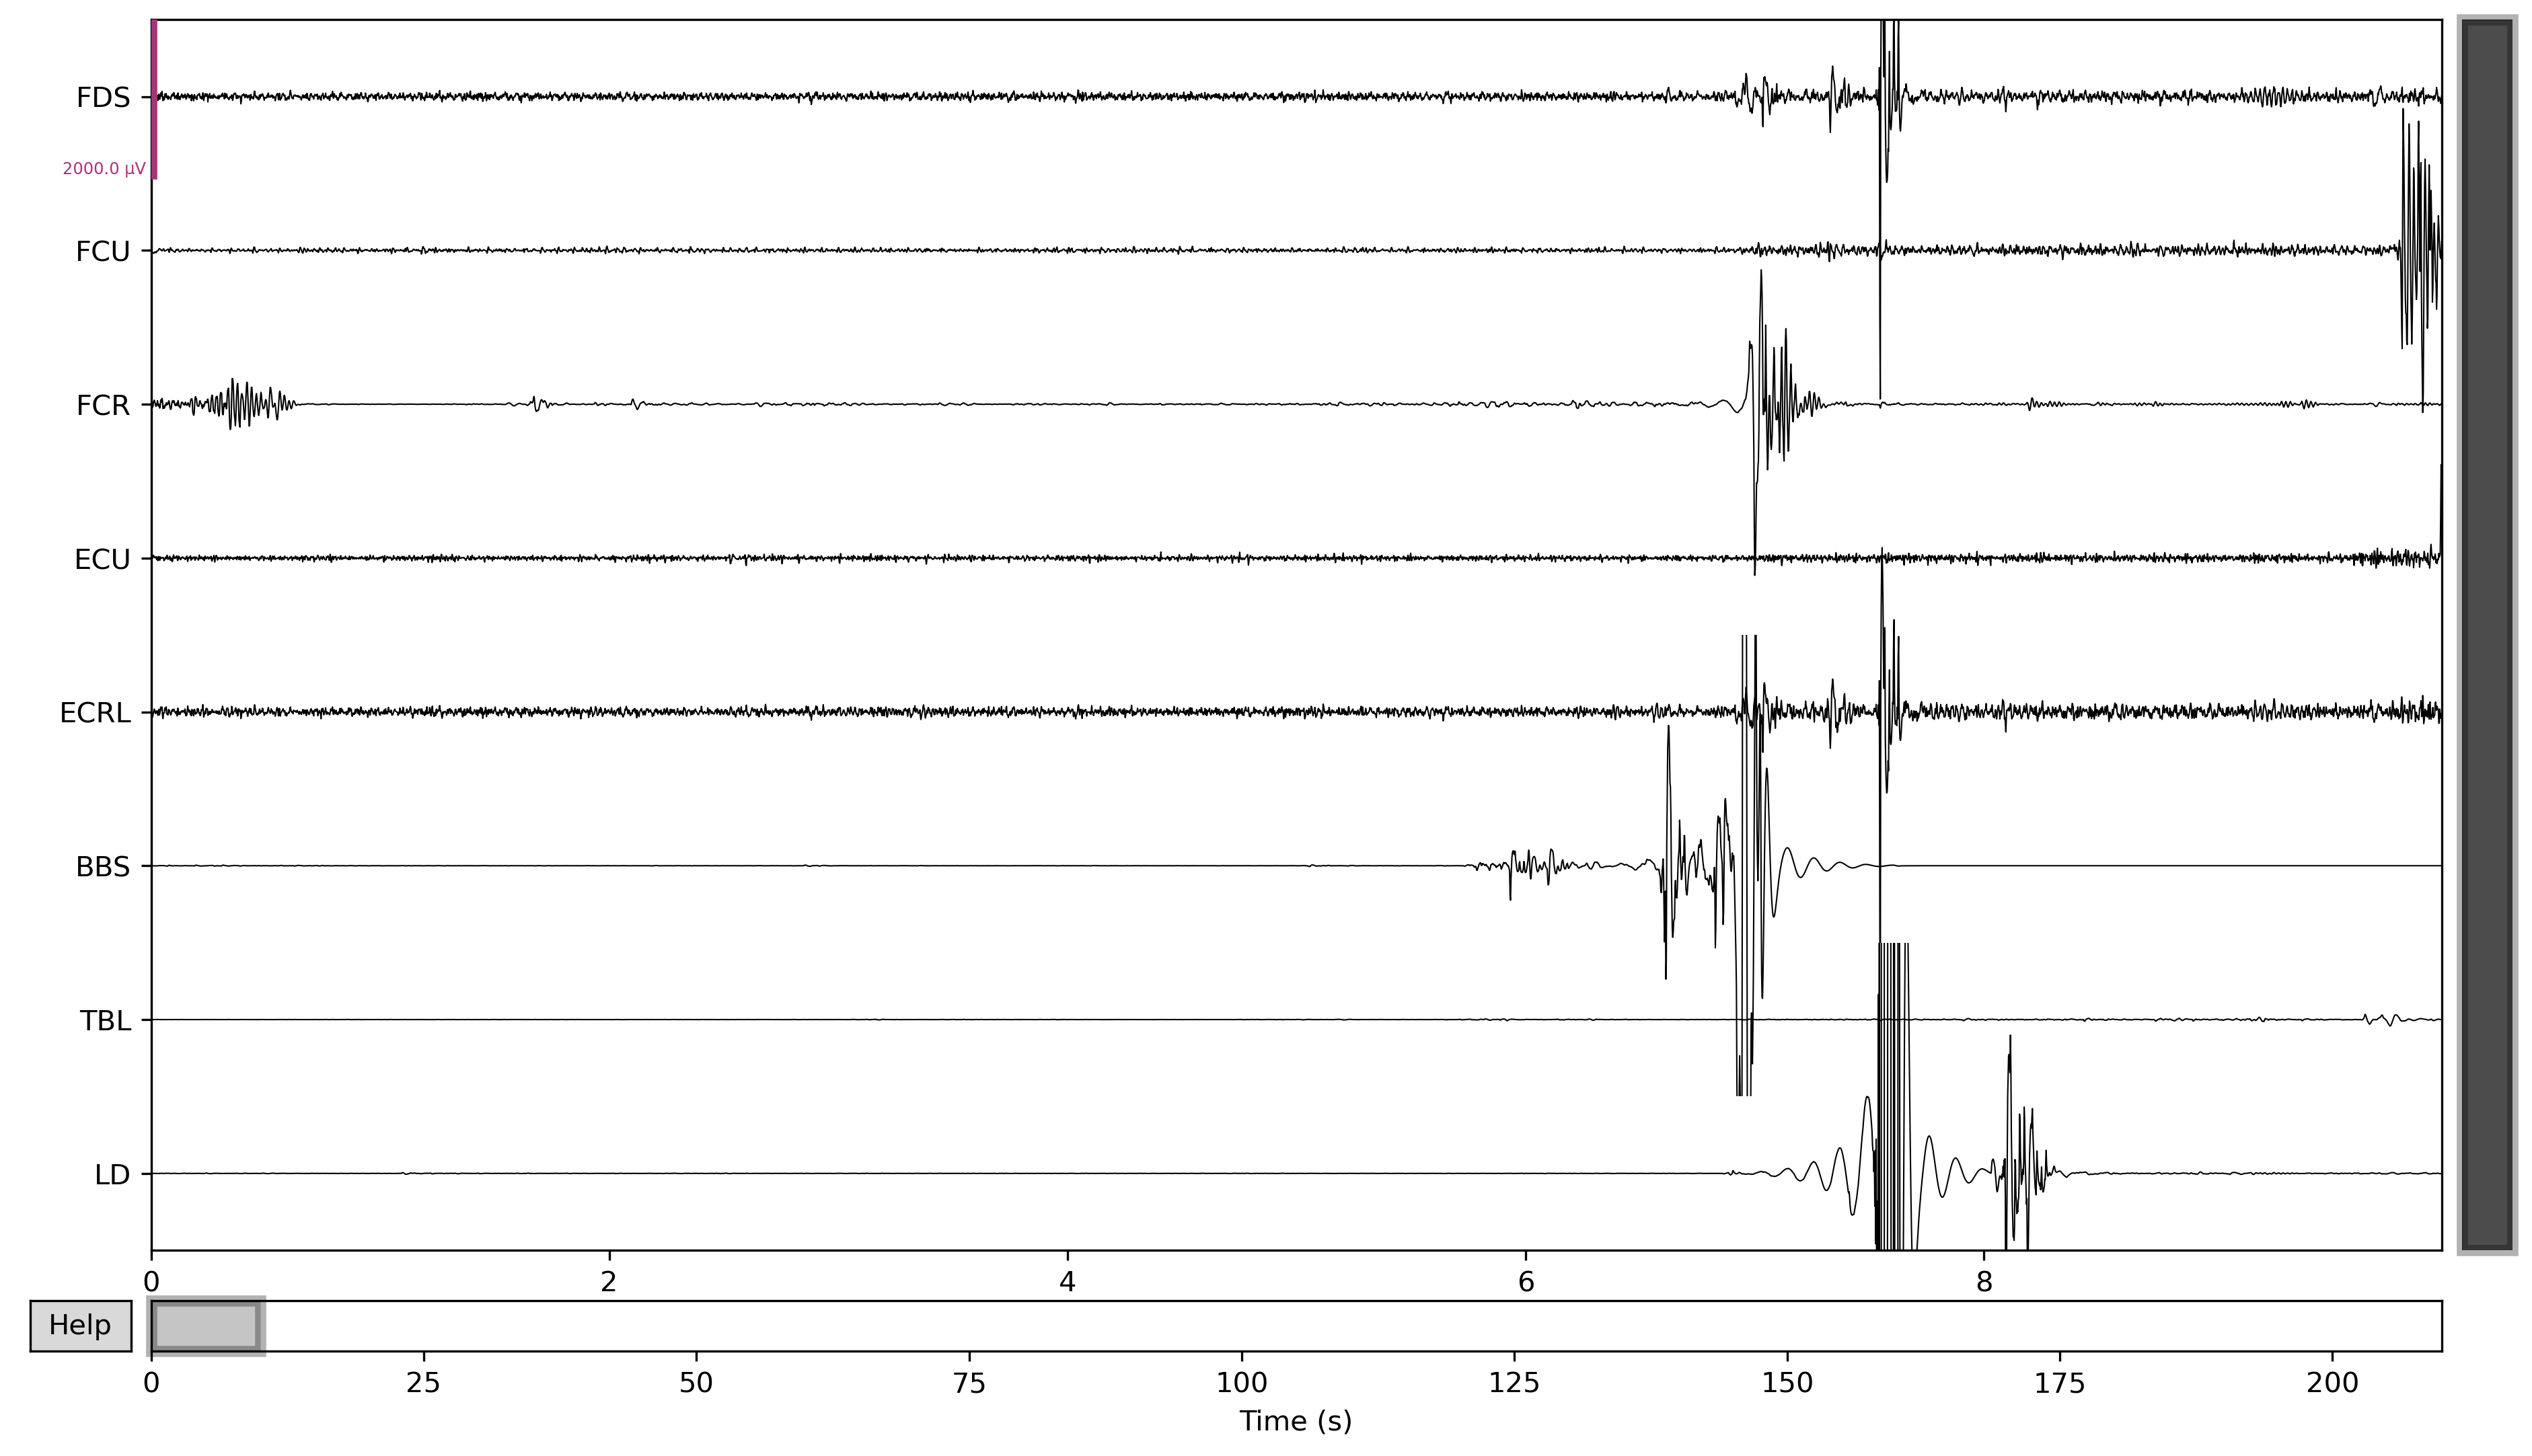

In [31]:
ch_types = ['emg'] * 8
ch_names = ['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
emg_data = pd.read_csv(r'E:\masterSJTU\MultiEEGEMG_stroke\subj59\subj59_iVC_s01.txt', header=None, skiprows=3,
                       sep=' ', usecols=np.arange(0, 8), skipfooter=0, engine='python')
emg_data=emg_data.T / 1e6
emg_raw = mne.io.RawArray(emg_data, info)
emg_raw.filter(l_freq=10, h_freq=200, picks='all')
emg_raw.resample(sfreq=sfreq_eeg)
emg_raw.plot()

# Utils: Muscle activation (normalized, rectified, filtered) calculate SPMI (with EMG rectification) and graph properties
## No need to 50Hz notch filter as the line noise is not prominant
## Parameter such as LP, BP should be further explored
## ref: 
- David (2003) An EMG-driven musculoskeletal model to estimate muscle forces and knee joint moments in vivo
- VAF in this article: https://www.nature.com/articles/s41598-020-65257-w#Sec2

In [ ]:
# bandpass to correct artifacts
emg_data2test = mne.filter.filter_data(emg_data,sfreq=1000, l_freq=20, h_freq=400, method = 'iir')
# plot to show the process
emg_raw2test = mne.io.RawArray(emg_data2test, info)
emg_raw2test.plot(title='bandpassed', duration=4)

# demean
emg_data2test -= emg_data2test.mean(axis = 1)[:, None]
# plot to show the process
# emg_raw2test = mne.io.RawArray(emg_data2test, info)
# emg_raw2test.plot(title='demeaned', duration=4)

# rectification
emg_data2test = np.abs(emg_data2test)
# plot to show the process
# emg_raw2test = mne.io.RawArray(emg_data2test, info)
# emg_raw2test.plot(title='rectified', duration=4)

# normalization
emg_data2test = emg_data2test / np.max(emg_data2test)
# emg_data2test /= emg_data2test.max(axis=1)[:, None] #  find max for each ch
# plot to show the process
# emg_raw2test = mne.io.RawArray(emg_data2test, info)
# emg_raw2test.plot(title='normalized', duration=4)

# low-pass smoothing, please note that negative values appear in this step
emg_data2test = mne.filter.filter_data(emg_data2test,sfreq=1000,l_freq=None, h_freq=4, method = 'iir')
# plot to show the process
# emg_raw2test = mne.io.RawArray(emg_data2test, info)
# emg_raw2test.plot(title='lowpassed', duration=4)

# muscle excitation (recursive filter)
d = 10 # 10ms
c1 = 0.5
c2 = 0.5
beta1 = c1+c2
beta2 = c1*c2
alpha = 1+beta1+beta2
muscle_excitation = np.zeros(emg_data2test.shape)
for i in range(emg_data2test.shape[1]-d):
    muscle_excitation[:,i+d] = alpha*emg_data2test[:,i] - beta1*muscle_excitation[:,i+d-1] - beta2*muscle_excitation[:,i+d-2]
# plot to show the process
# emg_raw2test = mne.io.RawArray(muscle_excitation, info)
# emg_raw2test.plot(title='muscle_excitation', duration=4)

# muscle activation
A = -1.5
muscle_activation = (np.exp(A*muscle_excitation) - 1) / (np.exp(A) -1)
# plot to show the process
# emg_raw2test = mne.io.RawArray(muscle_activation, info)
# emg_raw2test.plot(title='muscle_activation', duration=4)

# handle negative values
muscle_activation -= np.min(muscle_activation)

# non-negative matrix factorization iterate from 2 
# stopping condition: as the n_components increase, the reconstruction error (Frobenius norm of the matrix difference) does not reduce significantly
# In practice, (err(n + 2) - err(n)) / err(n) < 0.05 & (err(n + 1) - err(n)) / err(n) < 0.05
VAF_diff = 1
VAF_n = 0
n_components = 2
VAF_threshold = 0.85
VAF_diff_threshold = 0.05
while (VAF_diff > VAF_diff_threshold and VAF_n < VAF_threshold and n_components < 7): #  We require less than 6 components
    model_n = NMF(n_components=n_components, init='random', random_state=0, max_iter=500) #  max iteration is set to 500
    muscle_synergy = model_n.fit_transform(muscle_activation)
    synergy_factor = model_n.components_
    VAF_n = 1 - model_n.reconstruction_err_ / np.linalg.norm(muscle_activation) #  frobenius norm
    model_nPlus1 = NMF(n_components=n_components+1, init='random', random_state=0, max_iter=500)
    model_nPlus1.fit_transform(muscle_activation)
    VAF_nPlus1 = 1 - model_nPlus1.reconstruction_err_ / np.linalg.norm(muscle_activation)
    VAF_diff = np.abs(VAF_n - VAF_nPlus1)
    n_components +=1
    print(VAF_n)
    print(VAF_diff)

# Note synergy_factor should be down sampled to 500Hz before CMC calculation
# visualize the involvement of each synergy
plot_length = [18000, 40000] #  sfreq = 1000
df_synergy_factor = pd.DataFrame(synergy_factor.T, columns = ['f_synergy'+str(num_synergy) for num_synergy in range(synergy_factor.shape[0])])
plt.figure(figsize = (24,18))
for num_synergy in range(synergy_factor.shape[0]):
    sns.lineplot(x=df_synergy_factor.index[plot_length[0]:plot_length[1]], y='f_synergy' +str(num_synergy), \
          data=df_synergy_factor.iloc[plot_length[0]:plot_length[1], :], label='synergy' + str(num_synergy),
                 color=sns.color_palette(n_colors=synergy_factor.shape[0])[num_synergy])

df_muscle_synergy = pd.DataFrame(muscle_synergy.T, columns = ch_names)
fig, axes = plt.subplots(df_muscle_synergy.shape[0] // 4 + 1, 4, figsize=(24,18)) #  four cols
for num_synergy in range(df_muscle_synergy.shape[0]):
    sns.barplot(ax=axes[num_synergy // 4, num_synergy % 4],x=df_muscle_synergy.columns, y=df_muscle_synergy.iloc[num_synergy].values,
                color=sns.color_palette(n_colors=synergy_factor.shape[0])[num_synergy],
                label = 'synergy_' + str(num_synergy))
    axes[num_synergy // 4, num_synergy % 4].set_title('synergic module' + str(num_synergy))
# plt.fig()
plt.show()

Setting up band-pass filter from 20 - 4e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.00, 400.00 Hz: -6.02, -6.02 dB

Creating RawArray with float64 data, n_channels=8, n_times=209998
    Range : 0 ... 209997 =      0.000 ...   209.997 secs
Ready.
Setting up low-pass filter at 4 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 4.00 Hz: -6.02 dB



C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.6371523098743257
0.06614593571261851


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.7032982455869442
0.05849725215507917


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.7617954977420234
0.054057239931337486


C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0.8158527376733609
0.05337036809391338
